# Algorithm

In [1]:
import csv
from scipy import sparse
from sklearn.cluster import KMeans
import pandas as pd
import networkx as nx
import numpy as np
import time
from scipy.sparse import *
from scipy import *
from sklearn.model_selection import RandomizedSearchCV
import itertools
from tqdm import tqdm
import sys
import matplotlib.pyplot as plt
from scipy.spatial.distance import hamming
from numpy import linalg
from matplotlib.pyplot import figure
import random
import scipy.special
from networkx.algorithms.community import greedy_modularity_communities
import networkx.algorithms.community as nx_comm

<b>create_edge_list</b> : given the csv file of the synthetic transaction graph, return the edge list (csv format).

In [2]:
# file = name of the .csv file that contains the synthetic transaction graph
# name = name of the .csv file in output

def create_edge_list(file, name):
    #read csv file
    trans = pd.read_csv(file, sep = "|", names = ["id", "source", "target", "date", "time", "amount", "currency"])

    #convert string id nodes into integers id
    trans['source'] = trans.groupby(['source']).ngroup()
    trans['target'] = trans.groupby(['target']).ngroup()

    #delete parallel edges
    trans = trans.groupby(["source", "target"])["amount"].sum().reset_index()
    trans.to_csv(str(name)+'.csv', index=False, header=False)                        #create new csv file (edge_list) 
    return str(name)+'.csv' #file name

<b> adj_matrix </b> : given the edge list and the number of nodes, return the sparse adjacency matrix

In [3]:
def adj_matrix(edge_list, n):
    
    A = lil_matrix((n,n), dtype=float)
    f = open(edge_list)
    reader = csv.reader(f)
    
    for line in reader:
        A[int(line[0]),int(line[1])] = round(float(line[2]),2)   # the amount is rounded of two digits after the point
        
    return A

<b> kmeans </b>: run k-means from sklearn using k-means++ and Lloyd algorithm on the adjacency matrix

In [4]:
# k = number of clusters
# t = maximum number of iterations
# A = adjacency matrix

def kmeans(k, t, A):

    kmeans = KMeans(n_clusters=k, init = 'k-means++', algorithm='auto', max_iter=t).fit(A)
    
    # id_supernode : list of id_nodes in it
    partition = {i: np.where(kmeans.labels_ == i)[0] for i in range(k)}
    
    #id_node : id_supernode it belongs to
    supernode = {}
    for k,v in partition.items():
        for el in v:
            supernode[el] = k
  
    return partition, supernode

<b> lifted_density_matrix </b>: Given the density matrix (kxk), return the lifted density matrix (nxn) and Grass matrix (nxn)<br>

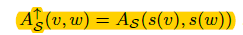 <br>

s(u) = supernode where u belongs to

In [5]:
def lifted_density_matrix(S, n, partition, supernode):
    
    t0 = time.time()
    S_lifted = lil_matrix((n,n), dtype=float) 
    S_grass = lil_matrix((n,n), dtype=float) 
    for i in tqdm(range(n)):
        for j in range(n):
            s_i = supernode[i]
            s_j = supernode[j]
            
            S_lifted[i,j] = S[s_i, s_j]
            if s_i != s_j :
                S_grass[i,j] = S_lifted[i,j] 
            elif i != j:
                S_grass[i,j] = S_lifted[i,j] * len(partition[s_j])/(len(partition[s_j])-1)   
            else:
                S_grass[i,j] = 0
    t1 = time.time()
    print('Running time A_S_lifted + Grass: %f' %(t1-t0))
    return S_lifted,S_grass 

<b> density_matrix </b>: optimized version for computing the density matrix of the summary. It uses the edge list.

# $A_S(i,j) =  \frac{\sum_{i\in V_i, j \in V_j}{A_G(i,j)}}{|V_i||V_j|} $

In [6]:
def density_matrix(k, edge_list, partition, A, is_sym, n, supernode):
    
    t0 = time.time()
    
    S_prob = dok_matrix((k,k))   #density matrix without considering weights
    S = dok_matrix((k,k))        #density matrix of the expected weights
    
    f = open(edge_list)
    reader = csv.reader(f)
    for el in reader:
        el[0]=int(el[0])
        el[1]=int(el[1])
        S_prob[supernode[el[0]], supernode[el[1]]] += 1   
        S[supernode[el[0]], supernode[el[1]]] +=  A[el[0],el[1]]
        
    for i in range(k): 
        for j in range(k): 
            den = len(partition[i])*len(partition[j])
            S_prob[i,j] = S_prob[i,j]/den
            S[i,j] = S[i,j]/den
            
    t1 = time.time()
    print('Running time S (kxk): %f' %(t1-t0))
    
    return S_prob, S
    #S_probs, S_probs_G = lifted_density_matrix(S_prob,n,partition,supernode)
    #S, S_G = lifted_density_matrix(S,n,partition,supernode)
    #return S_probs, S_probs_G, S, S_G

<b> summ </b>: run the entire pipeline returning the density matrix of the summary (kxk)

In [10]:
def summ_A(file, name, n, k, t):
    
    t0 = time.time()
    edge_list = create_edge_list(file, name)
    t1 = time.time()
    print('Running time edge_list: %f' %(t1-t0))
    
    t2 = time.time()
    A = adj_matrix(edge_list, n)
    t3  = time.time()
    print('Running time adj_matrix: %f' %(t3-t2))


    #partition given by the clustering
    t6 = time.time()
    partition, supernode = kmeans(k, t, A)
    t7 = time.time()
    print('Running time kmeans: %f' %(t7-t6))

    
    
    S_probs, S = density_matrix(k, edge_list, partition, A, True, n, supernode)                        


    return S_probs, S, partition, supernode

## Outputs

In [11]:
t0 = time.time()
k = 100
S_prob, S, partition, supernode = summ_A('1k_no_companies.csv', '1k', 1000, k, 20)
#S_probs, S_probs_G, S, S_G, partition, supernode = summ_A('1k_no_companies.csv', '1k', 1000, k, 20)
t1 = time.time()

print('Running time 1k nodes: %f' %(t1-t0)) 

Running time edge_list: 0.142841
Running time adj_matrix: 0.048625
Running time kmeans: 2.649664
Running time S (kxk): 0.924533
Running time 1k nodes: 3.766791


In [14]:
supernode

{100: 0,
 165: 0,
 377: 0,
 0: 1,
 1: 1,
 2: 1,
 4: 1,
 5: 1,
 6: 1,
 7: 1,
 8: 1,
 9: 1,
 10: 1,
 11: 1,
 12: 1,
 13: 1,
 14: 1,
 15: 1,
 16: 1,
 18: 1,
 19: 1,
 20: 1,
 21: 1,
 22: 1,
 23: 1,
 25: 1,
 27: 1,
 28: 1,
 29: 1,
 30: 1,
 31: 1,
 32: 1,
 33: 1,
 34: 1,
 35: 1,
 36: 1,
 37: 1,
 38: 1,
 41: 1,
 42: 1,
 43: 1,
 44: 1,
 45: 1,
 46: 1,
 47: 1,
 48: 1,
 49: 1,
 50: 1,
 51: 1,
 52: 1,
 53: 1,
 54: 1,
 55: 1,
 56: 1,
 57: 1,
 58: 1,
 60: 1,
 63: 1,
 64: 1,
 66: 1,
 67: 1,
 68: 1,
 69: 1,
 70: 1,
 71: 1,
 72: 1,
 73: 1,
 74: 1,
 75: 1,
 76: 1,
 78: 1,
 79: 1,
 81: 1,
 82: 1,
 83: 1,
 84: 1,
 85: 1,
 87: 1,
 88: 1,
 89: 1,
 90: 1,
 91: 1,
 92: 1,
 93: 1,
 94: 1,
 95: 1,
 96: 1,
 97: 1,
 98: 1,
 99: 1,
 101: 1,
 102: 1,
 103: 1,
 104: 1,
 105: 1,
 106: 1,
 107: 1,
 108: 1,
 109: 1,
 110: 1,
 111: 1,
 112: 1,
 113: 1,
 114: 1,
 115: 1,
 116: 1,
 117: 1,
 118: 1,
 119: 1,
 120: 1,
 121: 1,
 123: 1,
 128: 1,
 129: 1,
 130: 1,
 131: 1,
 132: 1,
 133: 1,
 134: 1,
 135: 1,
 136: 1,
 137: 1

In [24]:
t0 = time.time()
k = 500
S_prob, S, partition, supernode = summ_A('10k_no_companies.csv', '10k', 10000, k, 20)
t1 = time.time()

print('Total running time: %f' %(t1-t0)) 

Running time edge_list: 1.325089
Running time adj_matrix: 0.519290
Running time kmeans: 31.139348
Running time S (kxk): 15.490088
Total running time: 48.479753


In [8]:
t0 = time.time()
k = 500
S_prob, S, partition, supernode = summ_A('100k.csv', '100k.csv', 100000, k, 20)
t1 = time.time()

print('Total running time: %f' %(t1-t0)) 

Running time edge_list: 1.149290
Running time adj_matrix: 0.235073


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (500). Possibly due to duplicate points in X.
  import sys


Running time kmeans: 69.057533


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in double_scalars
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in double_scalars


Running time S (kxk): 86.887614
Total running time: 157.339406


## Thresholding

In [8]:
A = adj_matrix('edge_list_1k.csv', 1000)

In [100]:
# discretize 
# A -> 0 remains 0, values different from zeros became 1
#A_th = lil_matrix((1000,1000), dtype=float) 
#A_th[A>0] = 1


th = 0.75
# thresholding for number of SuperEdges
S_probs_th = lil_matrix((1000,1000), dtype=float) 
S_probs_th[S_probs<th] = 0
S_probs_th[S_probs>=th] = 1

# thresholding for l2 error
S_th = S
S_th[S_probs<th] = 0

In [101]:
#l2 error
print('Error l2: with A_S', linalg.norm(A.A-S_th.A))

Error l2: with A_S 22447551.554736502


In [102]:
#Number of SuperEdges
print('Edges in the Grass lifted summary matrix',np.count_nonzero(S_probs_th.A))

Edges in the Grass lifted summary matrix 857


## Cluster densities

In [51]:
# cluster : size
cluster={}
for k,v in partition.items():
    cluster[k] = len(v)
s = np.array([key for key, val in cluster.items() for _ in range(val)])

In [52]:
n = 1000

In [53]:
print('median', np.median(list(cluster.values())))
print('mean', np.mean(list(cluster.values())))
print('variance', np.var(list(cluster.values())))
print('max', np.max(list(cluster.values())))
print('max percentage', np.max(list(cluster.values()))/n)

median 1.0
mean 2.857142857142857
variance 880.185306122449
max 557
max percentage 0.557


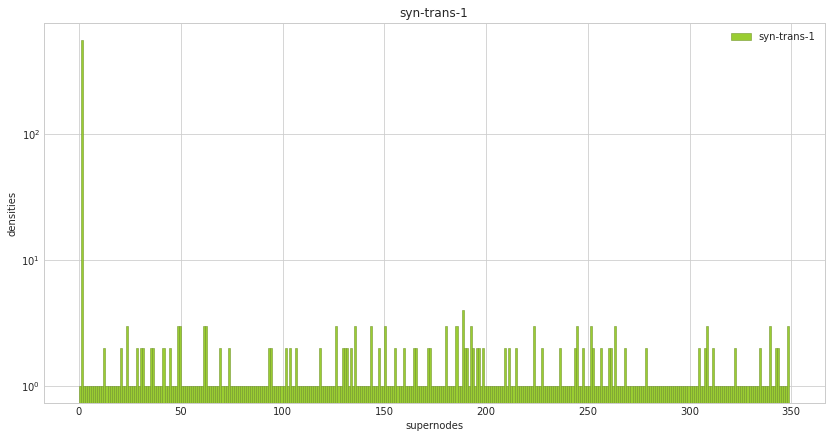

In [54]:
#cluster distribution

plt.figure(figsize=(14,7)) # Make it 14x7 inch
plt.style.use('seaborn-whitegrid') # nice and clean grid
plt.hist(s, bins=k, facecolor = 'yellowgreen', edgecolor='olivedrab',  linewidth=0.5, log=True, label = 'syn-trans-1')
plt.title('syn-trans-1') 
plt.xlabel('supernodes') 
plt.ylabel('densities') 
plt.legend(loc="upper right")
plt.show()

## nx queries


In [5]:
# build adj matrix for 1k nodes (input matrix)

#edge_list = create_edge_list('1k_no_companies.csv', 'edge_list_1k')
A = adj_matrix('edge_list_1k.csv', 1000)

In [6]:
#input
G = nx.from_numpy_matrix(np.matrix(A.A), create_using=nx.DiGraph)

In [23]:
#summary
s = nx.from_numpy_matrix(np.matrix(S.A), create_using=nx.DiGraph)

NameError: name 'S' is not defined

In [42]:
print('Error l2: with A_S', linalg.norm(A.A-S.A))

Error l2: with A_S 23003735.36661652


In [14]:
#diameter
t0 = time.time()
print(nx.diameter(s))
t1 = time.time()
print(round(t1-t0,2))

4
0.71


In [20]:
#Avg cluster coefficient
t0 = time.time()
print(nx.average_clustering(s))
t1 = time.time()
print(round(t1-t0,2))

0.19906030847138098
0.12


In [23]:
# minimum cut
t0 = time.time()
nx.minimum_node_cut(s)
t1 = time.time()
print(round(t1-t0,2))

50.71


In [40]:
mean(S.A)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: scipy.mean is deprecated and will be removed in SciPy 2.0.0, use numpy.mean instead
  """Entry point for launching an IPython kernel.


829.2967921200001

## Weights comparison

In [191]:
def get_edge_attributes(G, name):
    edges = G.edges(data=True)
    return [ x[-1]['weight'] for x in edges]

In [208]:
#w_G = get_edge_attributes(G, 'weight')
w_S = get_edge_attributes(s, 'weight')

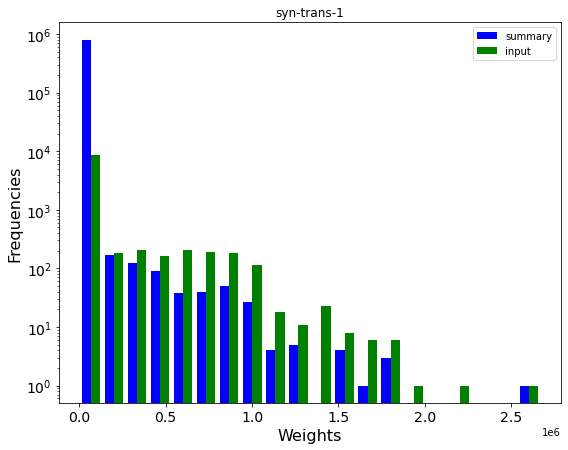

In [209]:
colors = ['b','g']
#plots the histogram
fig, ax1 = plt.subplots(figsize=(9,7))
ax1.hist([w_S,w_G],color=colors, bins=20, log=True, label = ['summary','input'])
#ax1.set_xlim(0,2.5e6)
plt.title("syn-trans-1")
plt.xlabel("Weights", fontsize=16)  
plt.ylabel("Frequencies", fontsize=16)
plt.legend(loc="upper right")
plt.xticks(fontsize=14)  
plt.yticks(fontsize=14)
plt.show()

## Degree queries

In [122]:
#save the errors for any node

s_out_tot = []
s_in_tot = []

In [19]:
# discretize 
# A -> 0 remains 0, values different from zeros became 1
#A[A>0] = 1
# grass -> negative values became 0, positive values 1 

#Th = 0.01, 0.02, 0.05, 0.1, 0.25, 0.5, 0.75
probs_G = lil_matrix((1000,1000), dtype=float) 
probs_G[S_probs_G<0.01]= 0
probs_G[S_prob_G>=0.01] = 1

NameError: name 'S_prob_G' is not defined

In [141]:
#discretize for weighted degree
S_G_dq = S_G 
S_G_dq[S_probs_G<0.75]= 0

In [142]:
#out degree queries percentage
s_out = []

for i in tqdm(range(1000)):
    sumA = np.sum(A[i,:])
    #sumS = np.sum(probs_G[i,:])
    sumS = np.sum(S_G_dq[i,:])
    s_out.append((abs(sumA - sumS))/sumA )
    
s_out_tot.append(round(np.mean(s_out),2))
print("Average error in adjacency queries", np.mean(s_out))

100%|██████████| 1000/1000 [00:00<00:00, 2370.01it/s]

Average error in adjacency queries 0.8990208462508021


In [143]:
#in degree queries percentage
s_in = []

for i in tqdm(range(1000)):
    sumA = np.sum(A[:,i])
    #sumS = np.sum(probs_G[:,i])
    sumS = np.sum(S_G_dq[:,i])
    s_in.append((abs(sumA - sumS))/sumA )

s_in_tot.append(round(np.mean(s_in),2))
print("Average error in adjacency queries", np.mean(s_in))

100%|██████████| 1000/1000 [00:02<00:00, 344.60it/s]

Average error in adjacency queries 0.8599457684608149


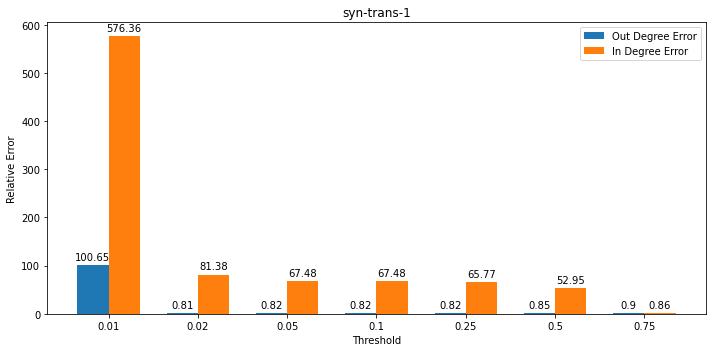

In [145]:
labels = [0.01, 0.02, 0.05, 0.1, 0.25, 0.5, 0.75]

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
fig.set_figheight(5)
fig.set_figwidth(10)
rects1 = ax.bar(x - width/2, s_out_tot , width, label='Out Degree Error')
rects2 = ax.bar(x + width/2, s_in_tot, width, label='In Degree Error')

# Add some text for labels, title and custom x-axis tick labels, etc.
#ax.set_ylim(0, 1.3)
ax.set_xlabel('Threshold')
ax.set_ylabel('Relative Error')
ax.set_title("syn-trans-1")
ax.set_xticks(x, labels)
ax.legend()

ax.bar_label(rects1, padding=3)
ax.bar_label(rects2, padding=3)

fig.tight_layout()

plt.show()

## Triangles

In [69]:
#first idea
t = np.sum(list(nx.triangles(s).values())) / 3
print(t)
t = 0
for i in range(k):
    if S_prob[i,i]!=0:
        t += scipy.special.binom(len(partition[i]),3)*S_prob[i,i]**3
print("Number of triangles: ", round(t))

1568.0
Number of triangles:  40


In [70]:
#second idea
t = 0  #sum(list(nx.triangles(s).values())) / 3
all_cliques= nx.enumerate_all_cliques(s)
t_list = [x for x in all_cliques if len(x)==3]
for idx,el in enumerate(t_list):
    edge1 = max(S_prob[el[0], el[1]], S_prob[el[1],el[0]]) #S_prob[el[0],el[1]] if S_prob[el[0],el[1]]!=0 else S_prob[el[1],el[0]]
    edge2 = max(S_prob[el[1], el[2]], S_prob[el[2],el[1]]) #S_prob[el[1],el[2]] if S_prob[el[1],el[2]]!=0 else S_prob[el[2],el[1]]
    edge3 = max(S_prob[el[0], el[2]], S_prob[el[2],el[0]]) #S_prob[el[2],el[0]] if S_prob[el[2],el[0]]!=0 else S_prob[el[0],el[2]]
    prob = edge1*edge2*edge3
    if prob==0:
        print('probs 0')
    t += len(partition[el[0]])*len(partition[el[1]])*len(partition[el[2]])/3*prob
print("Number of triangles: ", round(t))

Number of triangles:  61


In [34]:
#Riondato
t0 = time.time()
t = 0
for i in tqdm(range(k)):
    n_i = len(partition[i])
    pi_ii = S_prob[i,i] * n_i / (n_i - 1) if n_i > 1 else 0
    t += scipy.special.binom(n_i,3) * pi_ii**3
    for j in range(i+1, k):
        pi_ij = (S_prob[i,j] + S_prob[j,i]) - (S_prob[i,j] * S_prob[j,i])
        n_j = len(partition[j])
        pi_jj = S_prob[j,j] * n_j / (n_j-1) if n_j > 1 else 0
        t += pi_ij**2*(scipy.special.binom(n_i,2)*n_j*pi_ii + scipy.special.binom(n_j,2)*n_i*pi_jj)
        for w in range(j+1,k):
            n_w = len(partition[w])
            pi_jw = (S_prob[j,w] + S_prob[j,w]) - (S_prob[j,w] * S_prob[j,w])
            pi_wi = (S_prob[w,i] + S_prob[i,w]) - (S_prob[w,i] * S_prob[i,w])
            t += n_i*n_j*n_w*pi_ij*pi_jw*pi_wi
print("Expected Number of triangles: ", round(t))

t1 = time.time()
print('running time', round(t1-t0,2))

100%|██████████| 100/100 [00:13<00:00,  7.40it/s]

Expected Number of triangles:  382
running time 13.51


## Centrality

In [42]:
def precision(k, l1, l2):
    l3 = [value for value in l1 if value in l2]
    intersect = len(l3)
    return intersect/k

In [52]:
#summary
s = nx.from_numpy_matrix(np.matrix(S.A), create_using=nx.DiGraph)

In [53]:
prG = nx.pagerank(G)
prS = nx.pagerank(s)

In [54]:
#normalization for pagerank
for i in range(k):
    prS[i] = prS[i]/len(partition[i])

In [60]:
prG = nx.degree_centrality(G)
prS = nx.degree_centrality(s)

In [61]:
#normalization for the degree centrality
for i in range(k):
    if S_prob[i,i] !=0:
        prS[i] = prS[i] + (len(partition[i]) - 1)#*S_prob[i,i]

In [62]:
#assign the centrality of the supernode to the nodes inside it
prSG = {}
for k,v in prS.items():
    for el in partition[k]:
        prSG[el] = v

In [65]:
th = sorted(list(prSG.values()), reverse=True)[99]

In [66]:
for idx,el in enumerate(sorted(list(prSG.values()), reverse=True)):
    if el<th:
        print(idx)
        k2 = idx
        break

556


In [20]:
k1 = 100
l1 = sorted(prG, key=prG.get, reverse=True)[:k1]
l2 = sorted(prSG, key=prSG.get, reverse=True)[:k2]

# measures
r = precision(k1,l1,l2)
p = precision(k2,l1,l2)
print('Precision:', p)
print('Recall:', r)
print('f1 measure', 2*p*r/(p+r))

Precision: 0.04
Recall: 0.04
f1 measure 0.04


In [37]:
k1 = 100
l1 = sorted(prG, key=prG.get, reverse=True)[:k1]
l2 = sorted(prSG, key=prSG.get, reverse=True)[:k2]
#l3 = [partition[s].tolist() for s in l2]
#l4 = list(itertools.chain(*l3))[:100]
print('precision',precision(k2, l1, l2))
print('recall',precision(k1, l1, l2))

precision 0.155
recall 0.31


## Core decomposition

In [ ]:
coreG = nx.core_number(G)

In [ ]:
s.remove_edges_from(nx.selfloop_edges(s))
coreS = nx.core_number(s)

In [ ]:
coreS_dict = {}
for k, v in coreS.items():
    for node in partition[k]:
        coreS_dict[node] = v 

In [ ]:
#inner most core

l1 = [k for k in coreG.keys() if coreG[k]==max(coreG.values())]
l2 = [k for k in coreS.keys() if coreS[k]==max(coreS.values())]

print('Nodes with the largest core number in the input:', len(l1))
print('Nodes with the largest core number in the input:', len(l2))

# measures
r = precision(len(l1),l1,l2)
p = precision(len(l2),l1,l2)
print('Precision:', p)
print('Recall:', r)
print('f1 measure', 2*p*r/(p+r))

Nodes with the largest core number in the input: 8946
Nodes with the largest core number in the input: 628
Precision: 0.8789808917197452
Recall: 0.06170355466130114
f1 measure 0.11531230415709212


In [ ]:
#second inner most core

l1 = [k for k in coreG.keys() if coreG[k]==sorted(unique(list(coreG.values())), reverse=True)[1]]
l2 = [k for k in coreS.keys() if coreS[k]==sorted(unique(list(coreS.values())), reverse=True)[1]]

# measures
r = precision(len(l1),l1,l2)
p = precision(len(l2),l1,l2)
print('Precision:', p)
print('Recall:', r)
print('f1 measure', 2*p*r/(p+r))

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: scipy.unique is deprecated and will be removed in SciPy 2.0.0, use numpy.unique instead
  This is separate from the ipykernel package so we can avoid doing imports until


Precision: 0.09770114942528736
Recall: 0.028145695364238412
f1 measure 0.043701799485861184


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: scipy.unique is deprecated and will be removed in SciPy 2.0.0, use numpy.unique instead
  after removing the cwd from sys.path.


## Shortest Path

In [35]:
# sample 1000 couples of nodes 
sample1 = random.sample(G.nodes, 1000)
sample2 = random.sample(G.nodes, 1000)
couple = [list(x) for x in zip(sample1, sample2)]

In [37]:
sp = []
for couple in couple:
    sp.append(nx.shortest_path_length(G, source=couple[0], target=couple[1], weight= None, method='dijkstra'))

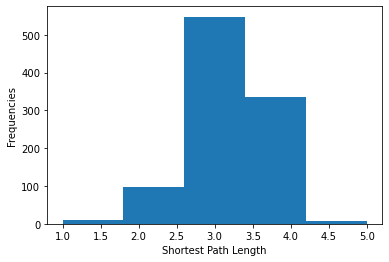

In [31]:
#Histogram of the sampled shortest path lengths for 1k

plt.hist(sp, bins=5)
plt.xlabel('Shortest Path Length')
plt.ylabel('Frequencies')

plt.show()

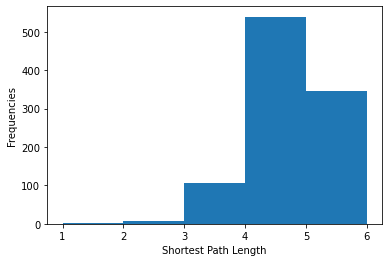

In [182]:
#Histogram of the sampled shortest path lengths for 10k

plt.hist(sp, bins=5)
plt.xlabel('Shortest Path Length')
plt.ylabel('Frequencies')

plt.show()

In [38]:
def shortest_distance(G,start,w):
    
    shortestDistance = float("inf")
    for n in G.neighbors(source): 
        currentDistance = nx.shortest_path_length(s, source=n, target=start, weight= w, method='dijkstra')
        if currentDistance < shortestDistance:
            target = n
        shortestDistance = min(currentDistance, shortestDistance)
        
    return shortestDistance+1 if w==None else shortestDistance+S[start,n]

In [24]:
def shortest_path(G, s, couple, w):
    avg_err_same_supernode = []
    percentage_err_same_supernode = []

    avg_err = []
    percentage_err = []

    for couple in sample:
        spG = nx.shortest_path_length(G, source=couple[0], target=couple[1], weight= w, method='dijkstra')
        s_i = supernode[couple[0]]
        s_j = supernode[couple[1]]
        if s_i == s_j:
            if S_prob[s_i, s_i] != 0:
                if w==None:
                    spS = 1
                else:
                    spS = S[s_i,s_j]
            else:
                spS = shortest_distance(s, s_i, w)

            avg_err_same_supernode.append(abs(spG-spS))
            percentage_err_same_supernode.append(abs(spG-spS)/spG)# if abs(spG-spS)/spG <1 else 1)

        else:
            spS = nx.shortest_path_length(s, source=s_i, target=s_j, weight=w, method='dijkstra')
            avg_err.append(abs(spG-spS))
            percentage_err.append(abs(spG-spS)/spG if abs(spG-spS)/spG<1 else 1) 

    print('Average Error Same Supernode', np.mean(avg_err_same_supernode))
    print('Percentage Error Same Supernode', np.mean(percentage_err_same_supernode))
    print('Average Error Different Supernode', np.mean(avg_err))
    print('Percentage Error Different Supernode', np.mean(percentage_err))

In [221]:
#unweighted version
shortest_path(G,s,couple,None)

Average Error Same Supernode 3.246774193548387
Percentage Error Same Supernode 0.7563709677419355
Average Error Different Supernode 3.0763157894736843
Percentage Error Different Supernode 0.7242543859649123


In [25]:
#weighted version
shortest_path(G,s,couple,'weight')

Average Error Same Supernode 606.9387876533331
Percentage Error Same Supernode 26.443320254200888
Average Error Different Supernode 1703.4423570435517
Percentage Error Different Supernode 0.9959118353116808


## Clusters

In [33]:
cluster={}
for k,v in partition.items():
    cluster[k] = len(v)

In [34]:
np.save('my_file.npy', cluster) 

In [ ]:
# sta tutto su testG.ipynb

## Community Detection

In [520]:
A = adj_matrix('edge_list_10k.csv', 10000)

In [521]:
#summary
s = nx.from_numpy_matrix(np.matrix(S.A), create_using=nx.DiGraph)

In [527]:
#input
G = nx.from_numpy_matrix(np.matrix(A.A), create_using=nx.DiGraph)

In [110]:
t0 = time.time()
community = greedy_modularity_communities(s, weight='weight')
t1 = time.time()
print('Running time:', round(t1-t0,2)) 

Running time: 3.09


In [111]:
# Assing to each node the community of the supernode it belongs to

communityS = []
for idx in range(len(community)):
    comm_idx = []
    for el in community[idx]:
        for node in partition[el]:
            comm_idx.append(node)
    communityS.append(comm_idx)

In [112]:
#modularity score
print(round(nx_comm.modularity(G, communityS),2))

0.13
